# ニューラルネットワーク入門

ここでは、ニューラルネットワークの最初の具体的な例を見てみましょう。
この例では、TensorFlowの高レベルAPIである「tf.keras」を使って、手書き数字を分類する方法を示しています。
すでに、tf.kerasや類似のライブラリを経験していなければ、この最初の例を全て理解することはできないでしょう。
この例の各要素の一つ一つを見て詳細に説明します。
まずは始めてみましょう。

ここでの課題は、手書き数字のグレースケール画像（28ピクセル×28ピクセル）を10個のカテゴリ（0〜9）に分類することです。
使用するデータセットは、機械学習で有名な古典的データセットである「MNIST」データセットです。
このデータセットには、1980年代に国立標準技術研究所 (NIST) に組み立てられた、60,000件のトレーニング画像と、10,000件のテスト画像が含まれています。
MNISTの問題を解くことは、ディープラーニングの"Hello World"を書くこととも考えられています。


MNISTデータセットには、tf.kerasに4つのnumpy配列のセットの形で読み込まれます。`mnist.load_data()`を実行すると、インターネットから実際のデータをダウンロードされます。

In [2]:
# ColabでのTensorFlow 2.xのインストール
try:
    # %tensorflow_version は Colab 上でのみ使えます
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

# TensorFlowとtf.kerasのバージョン確認
print(tf.version.VERSION)
print(tf.keras.__version__)

2.0.0-beta1
2.2.4-tf


In [3]:
from tensorflow.keras.datasets import mnist

# MNISTデータセットの読み込み
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

`train_images`と`train_labels`は学習用データである「トレーニングデータセット」となります。
トレーニングセットを使って学習したモデルを、`test_images`および`test_labels`からなる「テストデータセット」を使って評価します。
画像はnumpy配列としてエンコードされていて、ラベルは単純に0から9までの数字の配列です。
画像とラベルの間には1対1の対応があります。

トレーニングデータセットを見てみましょう。

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
len(train_labels)

60000

In [6]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

`train_images`の最初の文字を見てみましょう。

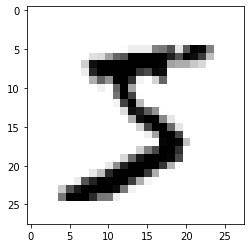

5


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(train_images[0], cmap='binary')
plt.show()
print(train_labels[0])

他の文字もいくつか見てみましょう。

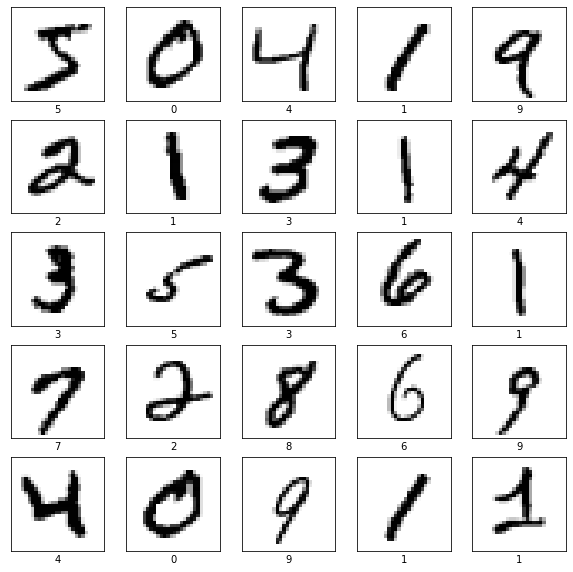

In [8]:
# matplotlibを使って、最初の25件分の画像データを表示。
# 画像データの下に、ラベルも表示。
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='binary')
    plt.xlabel(train_labels[i])
plt.show()

テストデータセットも見てみましょう。

In [9]:
test_images.shape

(10000, 28, 28)

In [10]:
len(test_labels)

10000

In [11]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

このデータセットを使って、画像がどのラベルなのかを分類してみましょう。流れとしては以下の通りです。

1. ニューラルネットワークモデルを構築します。
2. トレーニングデータセットをニューラルネットワークモデルに入力します。ネットワークモデルが画像とラベルの関連付けを学びます。
3. 学び終わったら、テストデータセットをニューラルネットワークモデルに入力して、テスト画像がどのラベルなのかを予測し、画像とラベルが一致するか検証します。

まず、ニューラルネットワークモデルを構築してみましょう。

In [12]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax'))

In [13]:
## 補足: 上記のモデル構築は以下のようにも書ける
## 1. Input Layerを明示的に追加
#model = models.Sequential()
#model.add(layers.Input((28 * 28,)))
#model.add(layers.Dense(512, activation='relu'))
#model.add(layers.Dense(10, activation='softmax'))

## 2. Sequential APIではなく、Functional APIを使う
#inputs = layers.Input((28 * 28,))
#x = layers.Dense(512, activation='relu')(inputs)
#outputs = layers.Dense(10, activation='softmax')(x)
#model = models.Model(inputs=inputs, outputs=outputs)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


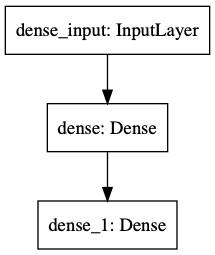

In [15]:
# オプション: 図でモデル構造を表示（graphviz本体のインストールをした後で、pipでpydotplusとgraphvizのインストールが必要)
#!pip install pydotplus
#!pip install graphviz
#from tensorflow.keras.utils import plot_model
#
#plot_model(model)

ニューラルネットワークの主な構成要素は、データ処理モジュールである「レイヤー」 (Layer)です。
これはデータの「フィルタ」のように考えることができます。
レイヤーにあるデータが入力されたら、より有用な形に変換されて出力されます。
うまくいけば、解きたい問題に対して意味のある表現に、レイヤーが変えてくれることになります。

ディープラーニングの大部分は、実際には単純なレイヤーが繋がってできています。

今回示したニューラルネットワークのモデルは、密結合（全結合）の層である2つの`Dense`（密な）層のシーケンスで構成されています。
2番目のレイヤー（最後のレイヤー）は10個の出力です。また活性化関数が`softmax`になっています。
この`softmax`のレイヤーでは、出力の合計を1にしてくれる、10個の確率値の配列を返してくれます。
この確率値は、現在の数字画像が、10の数字ラベルクラスの1つに属する確率になっています。

ニューラルネットワークのトレーニングするためには、「コンパイル」ステップとして、さらに3つの準備をする必要があります。

- 損失関数
    - ネットワークモデルが訓練データに対してどれくらい仕事がうまくいっているかを測定するものです。
        具体的には入力された画像データから得られた確率値と、正解ラベルの確率値との差（損失）を測定する方法です。
        損失が0に近ければ、うまくいっているといえます。
- オプティマイザ
    - ネットワークモデルに入っているデータと損失関数に基づいて、ネットワークモデルのパラメータを更新するものです。
- 指標
    - 今回は、正答率（正しく分類された画像の割合）を監視指標として確認します。

In [16]:
model.compile(
    loss = 'categorical_crossentropy',   # 損失関数は「categorical_crossentropy」
    optimizer = 'rmsprop',  # オプティマイザは「rmsprop」
    metrics = ['accuracy']  # 指標は「accuracy」（正答率）
)

これでニューラルネットワークモデルの構築が終わりました。

実際にトレーニングする前に、ニューラルネットワークモデルに合わせた形にデータを加工（前処理）します。

まず、全ての値が`[0, 1]`の範囲に収まるようにします。
こうすることで、学習が早く終わる（収束する）ようになります。

今回の画像データは`uint8`型の`(60000, 28, 28)`という形の配列に格納されています。値は`[0, 255]`の範囲です。
これを0と1の間の値を持つようにします。型は`uint8`型から`float32`型に変更します。
また、今回のニューラルネットワークモデルは入力を`(28 * 28,)`とベクトルで受け取るので、配列の構造も`(60000, 28*28)`に変更します。

In [17]:
# 最初の画像データの、変換前のデータ構造
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [18]:
train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28*28))
test_images = test_images.astype('float32') / 255

In [19]:
# 最初の画像データの、変換後のデータ構造
train_images[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

また、ラベルをカテゴリとしてコード化する必要があります。
今回は10個のカテゴリ（0から9の10個）に分類することになります。
例えば、ラベルが`5`である場合は`[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]`と、一つの要素だけ1で残りが0の配列に変換します。
（これを"one-hot エンコーディング"と呼んだりします）

In [20]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [21]:
# ラベルデータの確認
train_labels[0]  # 5

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

これでニューラルネットワークモデルをトレーニングする準備が整いました。
`fit`メソッドを使って、学習していきましょう。

In [22]:
# モデルの学習
# epochs: 全データを繰り返し学習する回数
# batch_size: 1度に投入する入力データ数
history = model.fit(train_images, train_labels, epochs = 5, batch_size = 128)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 71us/sample - loss: 0.2580 - accuracy: 0.9261
Epoch 2/5
60000/60000 [==============================] - 4s 72us/sample - loss: 0.1039 - accuracy: 0.9692
Epoch 3/5
60000/60000 [==============================] - 5s 79us/sample - loss: 0.0691 - accuracy: 0.9794
Epoch 4/5
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0500 - accuracy: 0.9843
Epoch 5/5
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0375 - accuracy: 0.9886


トレーニング中に2つの値が表示されています。

- loss: 損失
- accuracy: 正答率

トレーニングデータでの正答率は、すぐ98%程度（98.9%）に達します。

トレーニング中の損失と正答率の推移を、グラフ化してみましょう。
`model.fit()`のトレーニング中の各エポックでの損失と正答率を、`history`に格納しているので、これを使います。

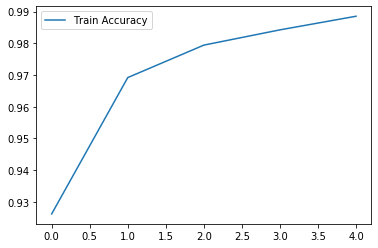

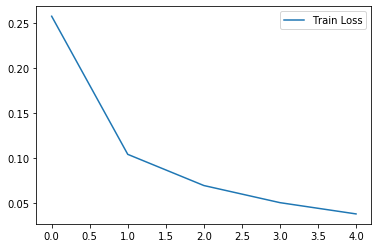

In [23]:
# 学習の推移をグラフ化
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']  # 学習データの正答率
loss = history.history['loss']  # 学習データの損失

epochs = range(len(acc))

plt.plot(epochs, acc, label='Train Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, label='Train Loss')
plt.legend()
plt.show()

トレーニングを重ねることで、損失は0に近づき、正答率は100%に近づいていくことがわかると思います。

ここでモデルがテストデータセットでうまくいくことを確認しましょう。

In [24]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 46us/sample - loss: 0.0699 - accuracy: 0.9799


In [25]:
print('test_acc: ', test_acc)

test_acc:  0.9799


今回のテストデータセットでは、正答率は98.0%でした。トレーニングデータセットの正答率より、低い結果になりました。
トレーニングデータでの正答率とテストデータでの正答率との間の差は「過学習(overfitting)」の一つの例です。
機械学習のモデルが、学習したデータよりも新しいデータに対して性能が悪くなる傾向です。

これで、最初の例は終わりです。最後に上記のコードの中から、ニューラルネットワークの構築・学習・推論部分のコードをまとめたものを以下に示しておきます。

2.0.0-beta1
2.2.4-tf
Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 56us/sample - loss: 0.2553 - accuracy: 0.9268
Epoch 2/5
60000/60000 [==============================] - 3s 52us/sample - loss: 0.1028 - accuracy: 0.9701
Epoch 3/5
60000/60000 [==============================] - 4s 59us/sample - loss: 0.0685 - accuracy: 0.9789
Epoch 4/5
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0511 - accuracy: 0.9848
Epoch 5/5
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0379 - accuracy: 0.9888


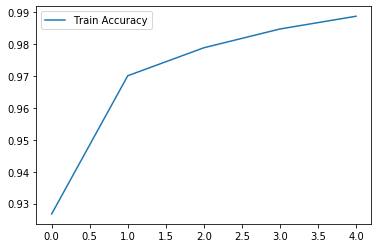

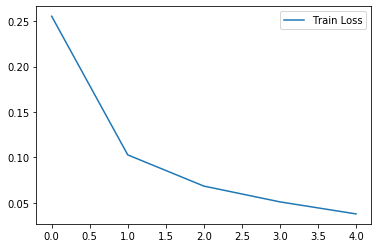

10000/10000 [==============================] - 1s 52us/sample - loss: 0.0717 - accuracy: 0.9773
test_acc:  0.9773


In [26]:
# ColabでのTensorFlow 2.xのインストール
try:
    # %tensorflow_version は Colab 上でのみ使えます
    %tensorflow_version 2.x
except Exception:
    pass

# ライブラリの読み込み
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

# TensorFlowとtf.kerasのバージョン確認
print(tf.version.VERSION)
print(tf.keras.__version__)

# MNISTデータセットの読み込み
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# モデルの構築
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax'))

# モデルのコンパイル
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

# 学習データの前処理
train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28*28))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# モデルの学習
history = model.fit(train_images, train_labels, epochs = 5, batch_size = 128)

# 学習の推移をグラフ化
acc = history.history['accuracy']  # 学習データの正答率
loss = history.history['loss']  # 学習データの損失
epochs = range(len(acc))

plt.plot(epochs, acc, label='Train Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, label='Train Loss')
plt.legend()
plt.show()

# 学習済モデルの評価
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test_acc: ', test_acc)